In [104]:
import datetime
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import hopsworks
import requests
import matplotlib.pyplot as plt
import joblib

today = datetime.datetime.now()
print(f"Inference date: {today}")

Inference date: 2026-01-01 14:16:34.112030


## <span style='color:#ff5f27'> Imports

# <span style="font-width:bold; font-size: 3rem; color:#333;">Batch Inference Pipeline</span>

In [105]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/fingrid from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('fingrid',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH`
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book
HopsworksSettings initialized!


## <span style="color:#ff5f27;"> Connect to Hopsworks Feature Store </span>

In [106]:
project = hopsworks.login()
fs = project.get_feature_store()
mr = project.get_model_registry()

2026-01-01 14:16:34,193 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-01 14:16:34,199 INFO: Initializing external client
2026-01-01 14:16:34,200 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-01 14:16:34,794 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-01 14:16:35,641 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286359


## <span style="color:#ff5f27;">Download the model from Model Registry</span>

In [107]:
# Load the model from local directory
model_path = f"{root_dir}/notebooks/fingrid/energy_model/energy_consumption_predictor.pkl"
retrieved_xgboost_model = joblib.load(model_path)

print(f"Model loaded from: {model_path}")
retrieved_xgboost_model

Model loaded from: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/notebooks/fingrid/energy_model/energy_consumption_predictor.pkl


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## <span style="color:#ff5f27;">Get Weather Forecast Features</span>

In [108]:
# Get future weather forecast data (matching airquality pattern)
weather_fg = fs.get_feature_group(
    name='weather_finland',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
print(f"Weather forecast data: {len(batch_data)} rows")
batch_data.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
Weather forecast data: 2 rows


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country
0,2026-01-01 18:00:00+00:00,-4.366667,0.0,100.0,25.966667,38.333333,122.333333,989.500000,0.0,Finland
1,2026-01-01 21:00:00+00:00,-4.066667,0.0,100.0,28.533333,42.300000,118.666667,987.566667,0.0,Finland


In [109]:
# Diagnose weather forecast data
print(f"Total rows fetched: {len(batch_data)}")
print(f"Date range in weather data: {batch_data['date'].min()} to {batch_data['date'].max()}")
print(f"Unique dates: {batch_data['date'].dt.date.nunique()}")

print(f"\nRows per date:")
print(batch_data['date'].dt.date.value_counts().sort_index())

print(f"\nFirst few rows:")
print(batch_data[['date', 'temperature_2m', 'wind_speed_10m']].head(20))

Total rows fetched: 2
Date range in weather data: 2026-01-01 18:00:00+00:00 to 2026-01-01 21:00:00+00:00
Unique dates: 1

Rows per date:
date
2026-01-01    2
Name: count, dtype: int64

First few rows:
                       date  temperature_2m  wind_speed_10m
0 2026-01-01 18:00:00+00:00       -4.366667       25.966667
1 2026-01-01 21:00:00+00:00       -4.066667       28.533333


### <span style="color:#ff5f27;">Add Temporal Features</span>

In [110]:
# Add temporal features to forecast data
batch_data['year'] = batch_data['date'].dt.year
batch_data['month'] = batch_data['date'].dt.month
batch_data['day'] = batch_data['date'].dt.day
batch_data['hour'] = batch_data['date'].dt.hour
batch_data['day_of_week'] = batch_data['date'].dt.dayofweek
batch_data['is_weekend'] = (batch_data['day_of_week'] >= 5).astype(int)
batch_data['week_of_year'] = batch_data['date'].dt.isocalendar().week

print("Features created:")
print(batch_data.columns.tolist())
batch_data.head()

Features created:
['date', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation', 'country', 'year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year']


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,year,month,day,hour,day_of_week,is_weekend,week_of_year
0,2026-01-01 18:00:00+00:00,-4.366667,0.0,100.0,25.966667,38.333333,122.333333,989.500000,0.0,Finland,2026,1,1,18,3,0,1
1,2026-01-01 21:00:00+00:00,-4.066667,0.0,100.0,28.533333,42.300000,118.666667,987.566667,0.0,Finland,2026,1,1,21,3,0,1


### <span style="color:#ff5f27;">Add Cyclic Features</span>

Convert temporal features to cyclic encoding (matching training pipeline)

In [111]:
# Add cyclic encoding for month (12 months in a year)
batch_data['month_sin'] = np.sin(2 * np.pi * batch_data['month'] / 12)
batch_data['month_cos'] = np.cos(2 * np.pi * batch_data['month'] / 12)

# Add cyclic encoding for hour (24 hours in a day)
batch_data['hour_sin'] = np.sin(2 * np.pi * batch_data['hour'] / 24)
batch_data['hour_cos'] = np.cos(2 * np.pi * batch_data['hour'] / 24)

# Add cyclic encoding for day_of_week (7 days in a week)
batch_data['day_of_week_sin'] = np.sin(2 * np.pi * batch_data['day_of_week'] / 7)
batch_data['day_of_week_cos'] = np.cos(2 * np.pi * batch_data['day_of_week'] / 7)

print("Cyclic features added")
batch_data.head()

Cyclic features added


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,...,hour,day_of_week,is_weekend,week_of_year,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
0,2026-01-01 18:00:00+00:00,-4.366667,0.0,100.0,25.966667,38.333333,122.333333,989.500000,0.0,Finland,...,18,3,0,1,0.5,0.866025,-1.000000,-1.836970e-16,0.433884,-0.900969
1,2026-01-01 21:00:00+00:00,-4.066667,0.0,100.0,28.533333,42.300000,118.666667,987.566667,0.0,Finland,...,21,3,0,1,0.5,0.866025,-0.707107,7.071068e-01,0.433884,-0.900969


### <span style="color:#ff5f27;">Making the predictions</span>

In [112]:
# Drop columns not used for prediction (including original cyclic features)
cols_to_drop = [col for col in ['consumption', 'date', 'country', 'month', 'hour', 'day_of_week'] if col in batch_data.columns]
X_pred = batch_data.drop(columns=cols_to_drop)

# Reorder columns to match the training data order
expected_order = ['year', 'day', 'is_weekend', 'week_of_year', 
                  'temperature_2m', 'precipitation', 'cloud_cover', 
                  'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 
                  'surface_pressure', 'shortwave_radiation',
                  'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 
                  'day_of_week_sin', 'day_of_week_cos']

# Only use columns that exist in both lists
X_pred = X_pred[[col for col in expected_order if col in X_pred.columns]]

print(f"Dropped columns: {cols_to_drop}")
print(f"Features for prediction: {list(X_pred.columns)}")

# Make predictions
batch_data['predicted_consumption'] = retrieved_xgboost_model.predict(X_pred)
batch_data

Dropped columns: ['date', 'country', 'month', 'hour', 'day_of_week']
Features for prediction: ['year', 'day', 'is_weekend', 'week_of_year', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,...,day_of_week,is_weekend,week_of_year,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,predicted_consumption
0,2026-01-01 18:00:00+00:00,-4.366667,0.0,100.0,25.966667,38.333333,122.333333,989.500000,0.0,Finland,...,3,0,1,0.5,0.866025,-1.000000,-1.836970e-16,0.433884,-0.900969,8628.415039
1,2026-01-01 21:00:00+00:00,-4.066667,0.0,100.0,28.533333,42.300000,118.666667,987.566667,0.0,Finland,...,3,0,1,0.5,0.866025,-0.707107,7.071068e-01,0.433884,-0.900969,8424.489258


### Create Forecast Graph

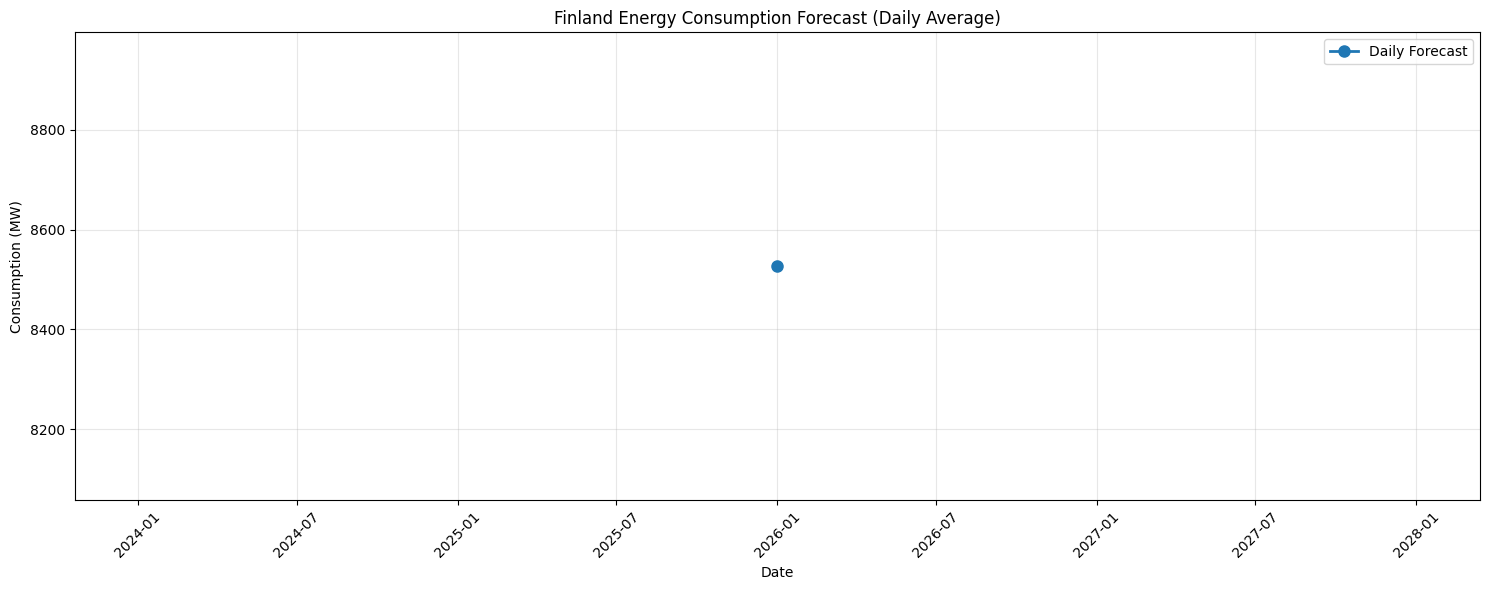

Forecast saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/docs/fingrid/assets/img/energy_forecast.png
Forecasting 1 days


In [113]:
# Resample to daily averages for cleaner visualization
batch_data['date'] = pd.to_datetime(batch_data['date'])
df_daily = batch_data.set_index('date').resample('D')[['predicted_consumption']].mean().reset_index()

# Plot forecast
plt.figure(figsize=(15, 6))
plt.plot(df_daily['date'], df_daily['predicted_consumption'], 
         linewidth=2, marker='o', markersize=8, label='Daily Forecast')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.title('Finland Energy Consumption Forecast (Daily Average)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
pred_file_path = f"{root_dir}/docs/fingrid/assets/img/energy_forecast.png"
os.makedirs(os.path.dirname(pred_file_path), exist_ok=True)
plt.savefig(pred_file_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Forecast saved to: {pred_file_path}")
print(f"Forecasting {len(df_daily)} days")

### <span style="color:#ff5f27;">Saving the predictions to a Monitoring Feature Group</span>

In [ ]:
# Add metadata for monitoring
batch_data['country'] = 'Finland'
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])

# Keep only relevant columns for monitoring
monitoring_data = batch_data[['date', 'country', 'days_before_forecast_day', 'predicted_consumption']].copy()

# Get or create monitoring feature group
monitor_fg = fs.get_or_create_feature_group(
    name='energy_predictions',
    description='Energy consumption prediction monitoring',
    version=1,
    primary_key=['country','date','days_before_forecast_day'],
    event_time="date"
)

monitor_fg.insert(monitoring_data, wait=True)
print(f"Inserted {len(monitoring_data)} predictions into monitoring feature group")

FeatureStoreException: Features are not compatible with Feature Group schema: 
 - year (type: 'int') is missing from input dataframe.
 - month (type: 'int') is missing from input dataframe.
 - day (type: 'int') is missing from input dataframe.
 - hour (type: 'int') is missing from input dataframe.
 - day_of_week (type: 'int') is missing from input dataframe.
 - is_weekend (type: 'int') is missing from input dataframe.
 - week_of_year (type: 'bigint') is missing from input dataframe.
 - consumption_lag_1 (type: 'double') is missing from input dataframe.
 - consumption_lag_2 (type: 'double') is missing from input dataframe.
 - consumption_lag_8 (type: 'double') is missing from input dataframe.
 - consumption_rolling_mean_24h (type: 'double') is missing from input dataframe.
 - consumption_rolling_std_24h (type: 'double') is missing from input dataframe.
 - temperature_2m (type: 'double') is missing from input dataframe.
 - precipitation (type: 'double') is missing from input dataframe.
 - cloud_cover (type: 'double') is missing from input dataframe.
 - wind_speed_10m (type: 'double') is missing from input dataframe.
 - wind_speed_100m (type: 'double') is missing from input dataframe.
 - wind_direction_10m (type: 'double') is missing from input dataframe.
 - surface_pressure (type: 'double') is missing from input dataframe.
 - shortwave_radiation (type: 'double') is missing from input dataframe.
Note that feature (or column) names are case insensitive and spaces are automatically replaced with underscores.